## Description
- This notebook will prepare the data and provide some descriptive analysis

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, MaxNLocator)

## Load Data

In [2]:
mypath = 'C:\\Users\\vivia\\Documents\\Kaggle\\Fitbit\\Data\\'
files = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f))]


Load into dictionary as there are many separate files to read in

In [3]:
dataframes={}
for file in files:
    name = str.split(file,"_merged")[0]
    dataframes[name] = pd.read_csv(mypath+file+'.csv')

In [4]:
files

['dailyActivity_merged',
 'dailyCalories_merged',
 'dailyIntensities_merged',
 'dailySteps_merged',
 'heartrate_seconds_merged',
 'hourlyCalories_merged',
 'hourlyIntensities_merged',
 'hourlySteps_merged',
 'minuteCaloriesNarrow_merged',
 'minuteCaloriesWide_merged',
 'minuteIntensitiesNarrow_merged',
 'minuteIntensitiesWide_merged',
 'minuteMETsNarrow_merged',
 'minuteSleep_merged',
 'minuteStepsNarrow_merged',
 'minuteStepsWide_merged',
 'sleepDay_merged',
 'weightLogInfo_merged']

## Merge Hourly Data

In [5]:
hourly_df1=dataframes['hourlyIntensities'].merge(dataframes['hourlySteps'],how='left',on=['Id','ActivityHour'])
hourly_df=hourly_df1.merge(dataframes['hourlyCalories'],how='left',on=['Id','ActivityHour'])


## Merge Minute Data

In [6]:
minute_df1=dataframes['minuteIntensitiesNarrow'].merge(dataframes['minuteStepsNarrow'],how='left', on=['Id','ActivityMinute'])
minute_df2=minute_df1.merge(dataframes['minuteCaloriesNarrow'], how='left',on=['Id','ActivityMinute'])
minute_df=minute_df2.merge(dataframes['minuteSleep'],how='left',left_on=['Id','ActivityMinute'],right_on=['Id','date'])


## Merge Daily Data

In [7]:
dataframes['sleepDay']['SleepDay']=pd.to_datetime(dataframes['sleepDay']['SleepDay'],infer_datetime_format=True).dt.strftime('%Y-%m-%d')
dataframes['dailyActivity']['ActivityDate']=pd.to_datetime(dataframes['dailyActivity']['ActivityDate']).dt.strftime('%Y-%m-%d')

In [8]:
daily_df=dataframes['sleepDay'].merge(dataframes['dailyActivity'],  how='right', left_on=['Id','SleepDay'],right_on=['Id','ActivityDate'])\

In [9]:
sub_df=daily_df[daily_df.columns.difference(['Id','SleepDay', 'ActivityDate'])]

## Descriptive Analysis

### Check for missing values
- Sleep Datasets don't contain all users
- NA rows will be removed for the sleep analysis

In [10]:
daily_df.isna().sum()

Id                            0
SleepDay                    530
TotalSleepRecords           530
TotalMinutesAsleep          530
TotalTimeInBed              530
ActivityDate                  0
TotalSteps                    0
TotalDistance                 0
TrackerDistance               0
LoggedActivitiesDistance      0
VeryActiveDistance            0
ModeratelyActiveDistance      0
LightActiveDistance           0
SedentaryActiveDistance       0
VeryActiveMinutes             0
FairlyActiveMinutes           0
LightlyActiveMinutes          0
SedentaryMinutes              0
Calories                      0
dtype: int64

In [11]:
hourly_df.isna().sum()

Id                  0
ActivityHour        0
TotalIntensity      0
AverageIntensity    0
StepTotal           0
Calories            0
dtype: int64

In [12]:
minute_df.isna().sum()

Id                      0
ActivityMinute          0
Intensity               0
Steps                   0
Calories                0
date              1200220
value             1200220
logId             1200220
dtype: int64

### Check that each dataset has the same number of users

In [13]:
print('Daily DF User Count:',daily_df.Id.nunique())
print('Hourly DF User Count:',hourly_df.Id.nunique())
print('Minute DF User Count:',minute_df.Id.nunique())

Daily DF User Count: 33
Hourly DF User Count: 33
Minute DF User Count: 33


## Analyze Correlations between Daily Variables

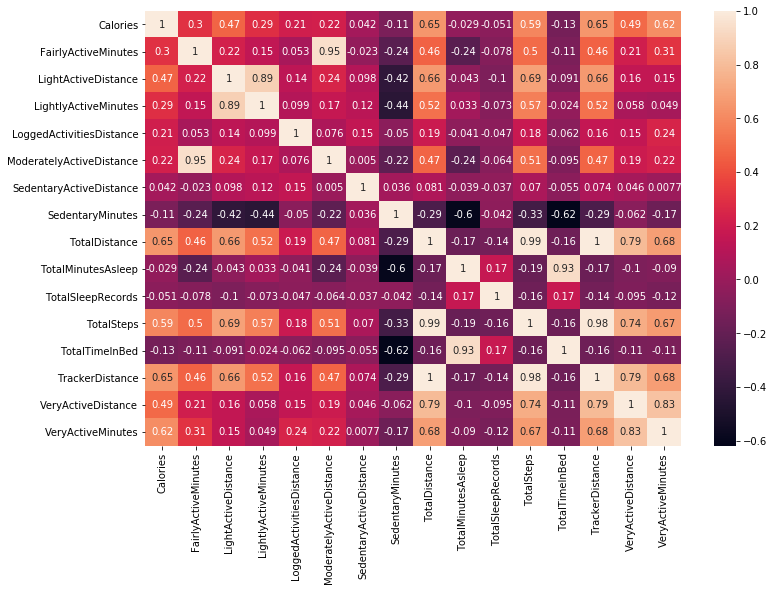

In [14]:
corr_df=sub_df.corr()
fig, ax = plt.subplots(figsize=(12, 8))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True)
plt.show()

## View Distribution of Very Active and Fairly Active Minutes to Group Users

- According to fitbit, you earn active minutes for time spent in the fat burn, cardio, or peak heart-rate zones


We want to group users based on active minutes. We will define total active minutes as:
    - Total Active Minutes =  Very Active Minutes + Fairly Active Minutes

In [15]:
daily_df['TotalActiveMinutes']=daily_df['VeryActiveMinutes']+daily_df['FairlyActiveMinutes']

In [16]:
# Calculate weekly average of active minutes
daily_df['ActivityDate']=pd.to_datetime(daily_df['ActivityDate'])
daily_df['WeekNumber'] = daily_df.ActivityDate.dt.week

In [17]:
weekly_df = daily_df[['Id','WeekNumber','FairlyActiveMinutes','VeryActiveMinutes','TotalActiveMinutes']].groupby(["Id","WeekNumber"]).mean().reset_index()

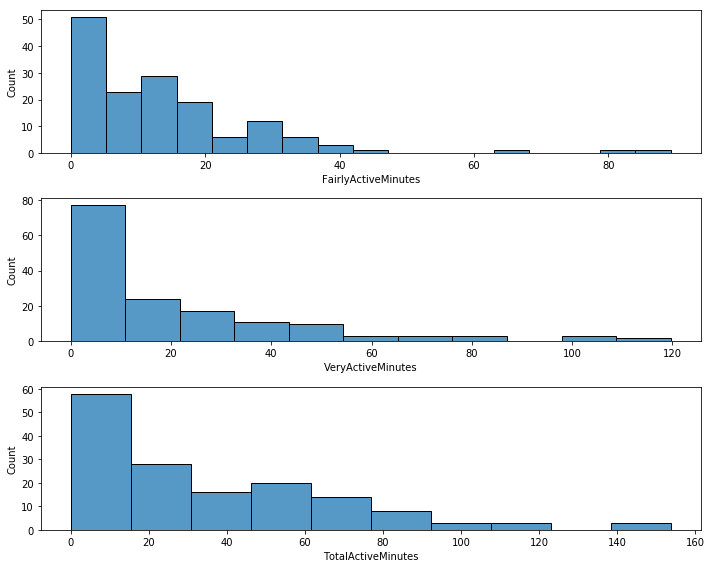

In [18]:
# View distribution of users based on active minutes per week
fig,ax = plt.subplots(3,figsize=(10, 8))
sns.histplot(data=weekly_df, x="FairlyActiveMinutes",ax=ax[0])
sns.histplot(data=weekly_df, x="VeryActiveMinutes",ax=ax[1])
sns.histplot(data=weekly_df, x="TotalActiveMinutes",ax=ax[2])
fig.tight_layout()
plt.show()

### Group Users into Active Groups

Group users based on their weekly average active minutes per day. The groupings were loosely based on the recommendations from the American Heart Association.

"The American Heart Association and World Health Organization recommend at least 150 minutes of moderate-intensity activity or 75 minutes of vigorous activity, or a combination of both, each week. If you earn an average of 22 Active Zone Minutes daily, you meet these recommendations, but you can change your goal based on your needs"
https://help.fitbit.com/articles/en_US/Help_article/1379.htm

#### The groups are as follows:
    - Very Active = Total Active Minutes >= 60
    - Active = Total Active Minutes >30 and < 60
    - Less Active = Total Active Minutes >=10 and <=30
    - Not Active = Total Active Minutes < 10

In [19]:
avg_min_df=weekly_df[['Id','TotalActiveMinutes']].groupby('Id').mean().reset_index()

In [20]:
avg_min_df['ActiveGroup']= np.where(
     avg_min_df['TotalActiveMinutes'].ge(60), 
    'VeryActive', 
     np.where(
        avg_min_df['TotalActiveMinutes'].between(30, 60, inclusive=False), 'Active',
    np.where(
        avg_min_df['TotalActiveMinutes'].between(10, 30, inclusive=True),'LessActive','NotActive'
     )
    )
    )

### View Distribution of Users across Active Groups

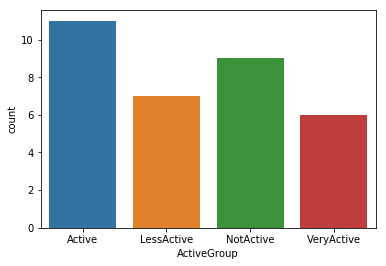

In [21]:
sns.countplot(data=avg_min_df, x="ActiveGroup")
plt.show()

### Merge Active Groups into DFs and Export

In [22]:
## Daily
daily_df=daily_df.merge(avg_min_df[['Id','ActiveGroup']],how='left',on='Id')
daily_df.to_csv('daily_df.csv',header=True,index=False)


## Hourly
hourly_df=hourly_df.merge(avg_min_df[['Id','ActiveGroup']],how='left',on='Id')
hourly_df.to_csv('hourly_df.csv',header=True,index=False)


## Minute
minute_df=minute_df.merge(avg_min_df[['Id','ActiveGroup']],how='left',on='Id')
minute_df.to_csv('minute_df.csv',header=True,index=False)